In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Задание по А/А тестированию

А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

Задача

Запустите A/A-тест

Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.

Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)

Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста
 

💡 Ответ: как найти причины поломки?

Вам доступна версия мобильного приложения (МП) каждого пользователя. Эту полезную информацию можно использовать для исследования проблемы:

Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. 
Возможно уже станет ясно где именно причины поломки

Посчитайте pvalue для каждой версии МП

Найдите версии, где pvalue < 0.05

Исключите версию с pvalue < 0.05 из основного датафрейма

Повторно запустите расчет FPR через A/A. Теперь FPR < альфа

Вы нашли поломку

**Загружаем ДФ**

In [2]:
df = pd.read_csv('hw_aa.csv', sep = ';')

In [3]:
df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


Разделим наш ДФ на две группы - experimentVariant 1 и 0, и возьмем колонку с покупками. Проведем А/А тест

  0%|          | 0/1000 [00:00<?, ?it/s]

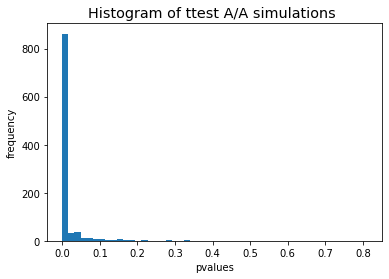

0.93

In [4]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Что-то пошло не так... Получаем различия в 94% случаев там, где их быть не должно
Поищем, что пошло не так:

In [5]:
df.groupby(['experimentVariant', 'version'], as_index = False) \
    .agg({'purchase': 'mean', 'Unnamed: 0' : 'count'})

,experimentVariant,version,purchase,Unnamed: 0
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


Судя по всему, проблема с версией v2.8.0 - в группе 0 и группе 1 разница в 45,9 раза.

In [6]:
df[df.experimentVariant == 1]['purchase']

0         0
2         0
3         0
4         0
5         0
         ..
127009    0
127010    0
127015    0
127016    0
127017    0
Name: purchase, Length: 63916, dtype: int64

  0%|          | 0/1000 [00:00<?, ?it/s]

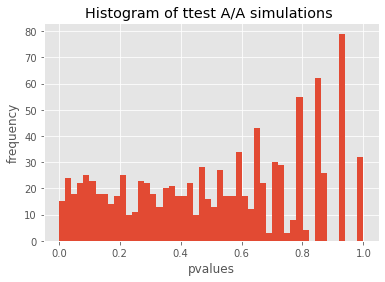

0.047

In [7]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Различия находятся в 4,3% случаев. Наш уровень значимости - не больше 5%, значит сейчас все работает корректно.

**Вывод №1 - поломка системы происходит в данных для версии приложения v2.8.0**

Для того, чтобы окончательно убедиться, что сломалась только v2.8.0 (или нет), потестируем остальные версии. 

  0%|          | 0/1000 [00:00<?, ?it/s]

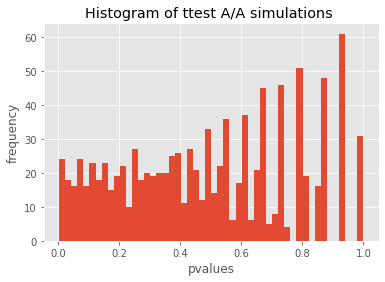

0.047

In [8]:
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version == 'v2.9.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version == 'v2.9.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

**Вывод №2 - версия v2.9.0 проходит, но на грани, периодически превышая 5%**

  0%|          | 0/1000 [00:00<?, ?it/s]

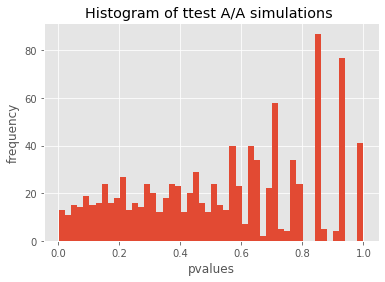

0.029

In [9]:
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version == 'v3.7.4.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version == 'v3.7.4.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

**Вывод №3 - версия v3.7.4.0 проходит**

  0%|          | 0/1000 [00:00<?, ?it/s]

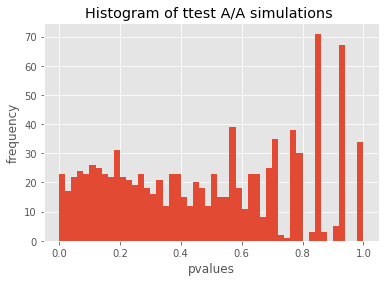

0.052

In [10]:
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version == 'v3.8.0.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version == 'v3.8.0.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

**Вывод №4 - версия v3.8.0.0 проходит, но на грани, периодически превышая 5%**